Edinburgh is great. It's my favorite city in the world. When I visit I sometimes stay in a places I find on AirBnb. I thought it would be fun to take a look at AirBnb data in Edinburgh since a few places on the internet offer it for free in nicely packeged csv files. Let's go!

We'll start by importing the libraries I used during this project...

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from scipy.stats.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

... and then we'll store the data from the csv in a pandas dataframe.

In [2]:
data = pd.read_csv('listings.csv')

/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Do reviews predict listing price?**

We can see a list of columns in the dataframe below. There's lots of data to choose from here. Let's start by investigating whether better review scores predict a higher price.

In [3]:
for col in data.columns:
    print(col)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
cal

We'll focus in on just the review and price columns and also drop any rows with missing values. There's enough data in this dataset that we don't need to worry too much about imputing values or finding other ways to preserve as much data as possible. 

In [4]:
relevant_data = data[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','price']]
cleaned_data = relevant_data.dropna(axis=0)

An awkward feature of this data set is that it encodes the price as a string as shown below. Let's strip away the dollar sign, the trailing zeros, and the dot. 

In [5]:
cleaned_data.iloc[0]['price']

'$80.00'

In [6]:
cleaned_data.loc[:,'price'] = cleaned_data.loc[:,'price'].str.lstrip('$')
cleaned_data.loc[:,'price'] = cleaned_data.loc[:,'price'].str.rstrip('0')
cleaned_data.loc[:,'price'] = cleaned_data.loc[:,'price'].str.rstrip('.')

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


This is better but it still won't let us turn the price data into integers. Below you can see that when a number has more than three digits it is broken up with a comma. We'll have to loop through the column and remove any commas from values long enough to have them. This isn't terribly efficient. However, our dataset is small enough that it will do for now. 

In [7]:
cleaned_data.iloc[571]['price']

'1,250'

In [8]:
for i in tqdm(range(cleaned_data.shape[0])):
    if len(cleaned_data.iloc[i]['price']) > 3:
        new_val = cleaned_data.iloc[i]['price'].translate({ord(','): None})
        cleaned_data.iat[i,7] = new_val

100%|██████████| 10802/10802 [00:02<00:00, 4180.79it/s]


Now that we have preprocessed our data we can get on with the investigation itself. Lets split our data into X and y sections, as well as training and testing sets. We will also set the y values to be integers.

In [9]:
X = cleaned_data[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

In [10]:
y = cleaned_data['price']
y = y.astype(int)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we perform linear regression on the data. We normalise the data since the price values and review values cover quite different scales. Normalisation fits them all to the same scale.

We then calculate the r^2 score. It's very close to zero which suggests that this model does not have much explanatory power. Most people give the best review they can, unless something was really bad so we shouldn't be surprised by the lack of predictive power reviews offer. 

In [13]:
lm_model = LinearRegression(normalize=True)

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test) 

rsquared_score = r2_score(y_test, y_test_preds)

rsquared_score

0.0038476744336496393

**How does price vary by neighbourhood?**

Let's turn to a different question now. Which areas of Edinburgh are more expensive than others? We'll only need the neighbourhood and price columns for this question so let's get them

In [14]:
# Price in each neighbourhood
df = pd.DataFrame(data[['neighbourhood','price']]).sort_values(by=['neighbourhood'])

We need both of these values so we'll any rows missing one or both of them.

In [15]:
df = df.dropna()

In [16]:
df.neighbourhood.values

array(['Bruntsfield', 'Bruntsfield', 'Bruntsfield', ..., 'West End',
       'West End', 'West End'], dtype=object)

In [17]:
df.price.values

array(['$56.00', '$50.00', '$26.00', ..., '$341.00', '$50.00', '$34.00'],
      dtype=object)

We'll preprocess the price column again so it is in a usable integer format. Let's also convert the prices to pounds since that's the currency I'll be using next time I book. 

In [18]:
df.loc[:,'price'] = df.loc[:,'price'].str.lstrip('$')
df.loc[:,'price'] = df.loc[:,'price'].str.rstrip('0')
df.loc[:,'price'] = df.loc[:,'price'].str.rstrip('.')

for i in tqdm(range(df.shape[0])):
    if len(df.iloc[i]['price']) > 3:
        new_val = df.iloc[i]['price'].translate({ord(','): None})
        df.iat[i,1] = new_val
        
df['price'] = df['price'].astype(int)

df['price'] *= 0.76 # The $ to £ exchange last time I checked

100%|██████████| 9737/9737 [00:01<00:00, 6177.61it/s]


It looks like the average price across Edinburgh is just over £80 a night. 

In [19]:
df['price'].mean()

81.86917941871165

Now let's calculate the mean for each area and sort them in descending order. Finally, we'll plot a bar chart of the results.

In [20]:
keys = df.groupby(['neighbourhood']).mean()['price'].sort_values().keys()
values = df.groupby(['neighbourhood']).mean()['price'].sort_values().values

Text(0.5,1,'AirBnb Prices in Edinburgh Neighbourhoods')

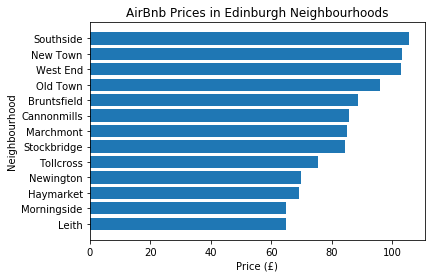

In [21]:
plt.barh(keys, values)
plt.xlabel('Price (£)')
plt.ylabel('Neighbourhood')
plt.title('AirBnb Prices in Edinburgh Neighbourhoods')

Interesting! There's quite some variation which does pass my smell test. Leith is definitely underrated though. Hopefully they'll extend the tram there before long and then it will surely climb up the rankings a bit!

**Does adding more listings lower the average price in an area?**

Let's see if more people signing up to host on airbnb correlates with prices suppressing prices. I found another site offering Airbnb data for the years 2014 to 2017. I'll use them for this analysis. 

In [22]:
data_2014 = pd.read_csv('edinburgh/tomslee_airbnb_edinburgh_0032_2014-05-25.csv')
data_2017 = pd.read_csv('edinburgh/tomslee_airbnb_edinburgh_1472_2017-07-22.csv')

In [23]:
df_2014 = data_2014[['neighborhood', 'price']]
df_2017 = data_2017[['neighborhood', 'price']]

This data source does not encode prices as strings which is convenient! What we do need to watch out for though are areas being added between 2014 and 2017. We are only interested for now in areas represented in both dataframes so let's drop any rows that weren't added until after 2014.

In [24]:
rows = []
for i in range(df_2017.shape[0]):
        if df_2017.iloc[i]['neighborhood'] not in df_2014.neighborhood.values:
            rows.append(i)
df_2017 = df_2017.drop(rows)

In [25]:
# df_2014.neighborhood.value_counts()
# df_2017.neighborhood.value_counts()

In order to compare the results side by side, let's sort everything alphabetically.

In [26]:
df_2014_places = df_2014.neighborhood.value_counts().keys().sort_values()
df_2014_quantity = [df_2014.neighborhood.value_counts()[n] for n in df_2014_places]

df_2017_places = df_2017.neighborhood.value_counts().keys().sort_values()
df_2017_quantity = [df_2017.neighborhood.value_counts()[n] for n in df_2017_places]

I'm interested in both the supply and the price so let's get both the supply and prices for each year.

In [27]:
quantity_2017 = {}

for i in range(len(df_2017_places)):
    quantity_2017[df_2017_places[i]] = df_2017_quantity[i]
    
quantity_2014 = {}

for i in range(len(df_2014_places)):
    quantity_2014[df_2014_places[i]] = df_2014_quantity[i]

In [39]:
# print(quantity_2017.keys())
# print(quantity_2017.values())

In [29]:
keys_2014 = df_2014.groupby(['neighborhood']).mean()['price'].keys()
values_2014 = df_2014.groupby(['neighborhood']).mean()['price'].values

In [30]:
keys_2017 = df_2017.groupby(['neighborhood']).mean()['price'].keys()
values_2017 = df_2017.groupby(['neighborhood']).mean()['price'].values

And now let's plot the results!

Text(0.5,0,'Price ($)')

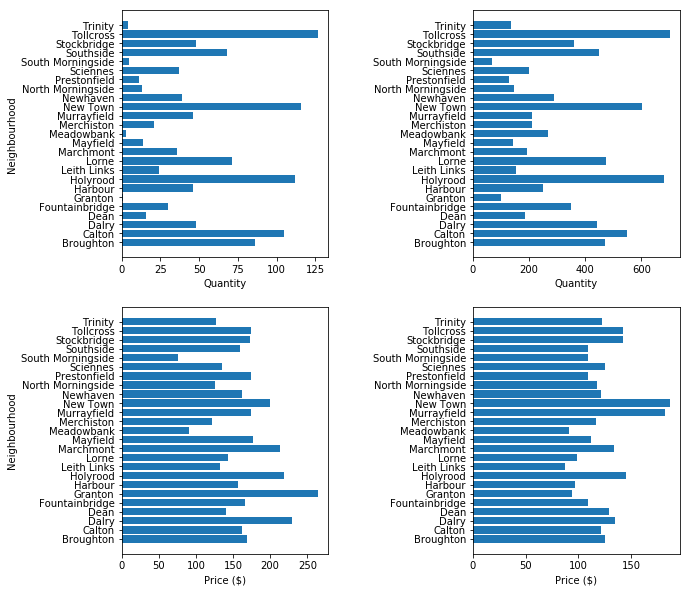

In [31]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.barh(range(len(quantity_2014)), list(quantity_2014.values()))
plt.yticks(range(len(quantity_2014)), list(quantity_2014.keys()))
plt.xlabel('Quantity')
plt.ylabel('Neighbourhood')

plt.subplot(2,2,2)
plt.barh(range(len(quantity_2017)), list(quantity_2017.values()))
plt.yticks(range(len(quantity_2017)), list(quantity_2017.keys()))
plt.xlabel('Quantity')

plt.subplot(2, 2, 3)
plt.subplots_adjust(wspace=0.7)
plt.barh(keys_2014, values_2014)
plt.xlabel('Price ($)')
plt.ylabel('Neighbourhood')

plt.subplot(2, 2, 4)
plt.barh(keys_2017, values_2017)
plt.xlabel('Price ($)')

It's possible to eyeball a few changes, but it would be easier if we just plotted the change in quantity on the market and the change in price.

In [32]:
diff_dict_quantity = {key: quantity_2017[key] - quantity_2014.get(key, 0) for key in quantity_2017.keys()}

In [33]:
diff_price = values_2017 - values_2014

Text(0.5,0,'Price ($)')

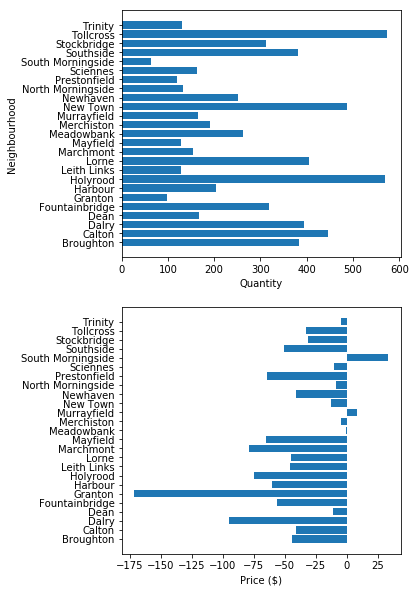

In [34]:
plt.figure(figsize=(5,10))

plt.subplot(2, 1, 1)
plt.barh(range(len(diff_dict_quantity)), list(diff_dict_quantity.values()))
plt.yticks(range(len(diff_dict_quantity)), list(diff_dict_quantity.keys()))
plt.xlabel('Quantity')
plt.ylabel('Neighbourhood')

plt.subplot(2, 1, 2)
plt.barh(keys_2017, diff_price)
plt.xlabel('Price ($)')

Now we can see that as supply went up everywhere prices did generally fall. However, is this trend significant? The supply in South Morningside went up the least and was where prices went *up* the most. Meanwhile however, Granton added the second lowest amount of supply and prices there went *down* the most.

In order to test the significance of this trend, I'll normalise the change in supply and price data and then calculate the pearsonr values for them. 

In [40]:
supply = np.array(list(diff_dict_quantity.values()))
price = np.array(list(diff_price))

In [41]:
normalised_supply = normalize(supply.reshape(1,-1))
normalised_price = normalize(price.reshape(1,-1))

In [42]:
pearsonr(normalised_supply.squeeze(), normalised_price.squeeze())

(-0.09477330945128504, 0.6522612861079518)

So there it is. There is only a very small (-0.09) trend in the the direction we were expecting and a significance of 0.65 is not statistically significant at all. To really investigate this relationship further, we would have to control for some factors, and possibly look at data from other time periods as well. 

The 2014 numbers are interesting though because they were scraped only about a month before Edinburgh's tram began running from the Airport into the city centre. Going forward it would be interesting to investigate whether the areas close to the tram's route have been able to raise their prices since they are now in a much more convenient location for visitors to the city. 